#  Tune footprint

## Quadrupoles
$\begin{aligned}\delta Q_{1,x} &= \frac{1}{4\pi} K_{N_1}\beta_x\\\delta Q_{1,y} &= -\frac{1}{4\pi} K_{N_1}\beta_y\end{aligned}$

## Octupoles
$\begin{aligned}\delta Q_{3,x} &= \frac{3}{8\pi}\left(\frac{K_{N_3}}{3!}\right)\Big[\beta_x^2J_x - 2\beta_x\beta_yJ_y\Big]\\\delta Q_{3,y} &=\frac{3}{8\pi}\left(\frac{K_{N_3}}{3!}\right)\Big[\beta_y^2J_y - 2\beta_y\beta_xJ_x\Big] \end{aligned}$


In [14]:
np.math.factorial(3)

6

In [79]:
pwd

'/home/pbelange/abp/footprint'

(0.295, 0.34500000000000003)

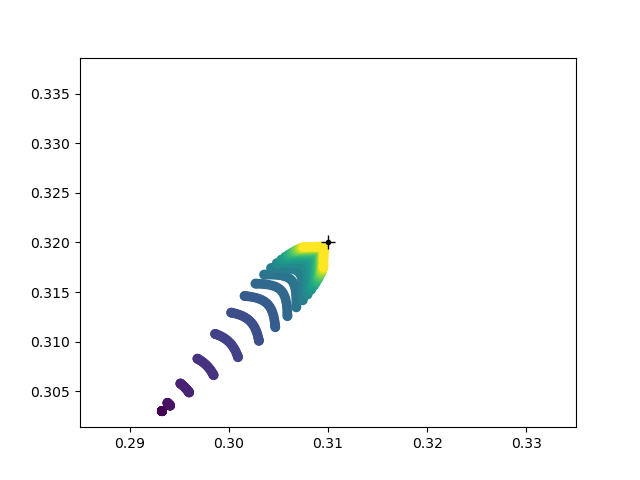

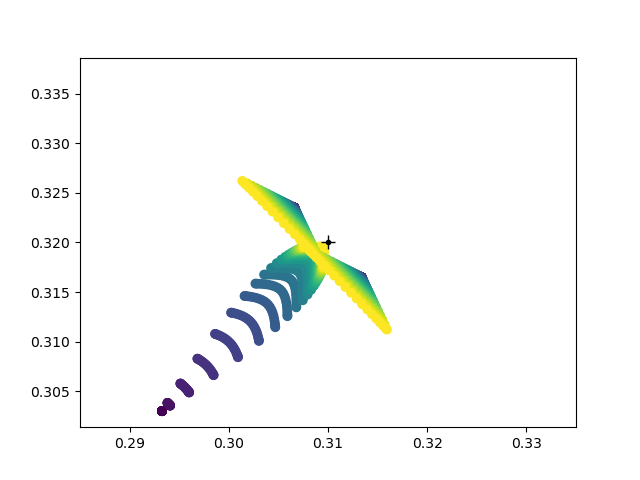

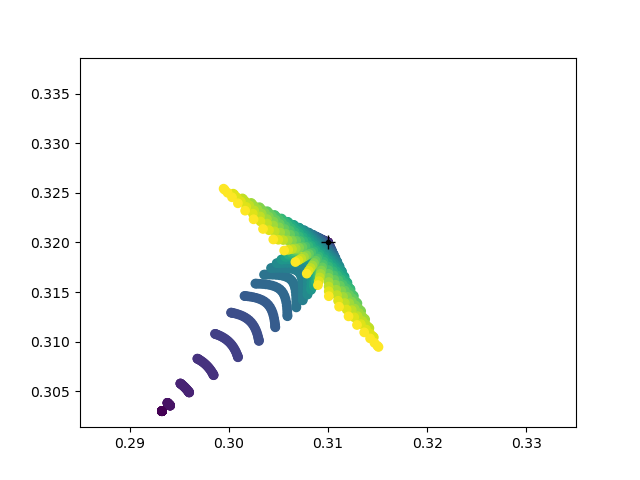

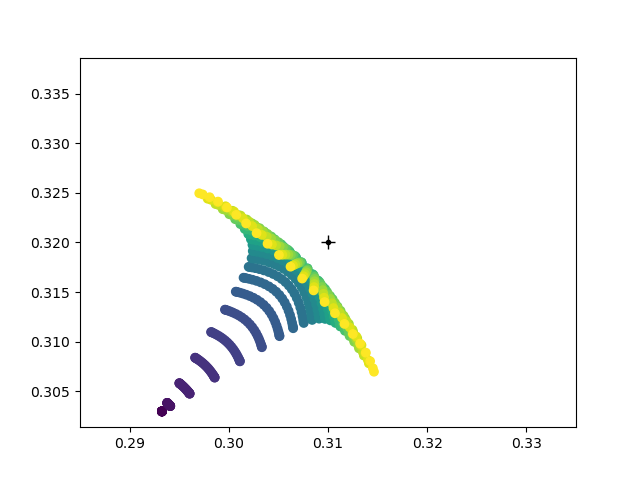

In [39]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as sciSpec

import Backend.Constants as cst
import Backend.Footprint as fp
import Backend.WCTools as WCTools


import scipy.integrate as integrate
import scipy.special as sciSpec



def get_LongRange(coords,knl,twiss):
    betx,bety = twiss['betx'],twiss['bety']
    
    # Quadrupole contribution
    DQx = 1/(4*np.pi)*knl[1]*betx
    DQy = -1/(4*np.pi)*knl[1]*bety
    
    
    # Quadrupole contribution
    DQx += 3/(8*np.pi)*(knl[3]/np.math.factorial(3))*(betx**2 * coords['J_x'] - 2*betx*bety*coords['J_y'])
    DQy += 3/(8*np.pi)*(knl[3]/np.math.factorial(3))*(bety**2 * coords['J_y'] - 2*bety*betx*coords['J_x'])
    
    return DQx,DQy

    
def get_HeadOn(coords,N_p,E,emitt,twiss):
    betx,bety = twiss['betx'],twiss['bety']   
    Jx,Jy = np.array(coords['J_x']),np.array(coords['J_y'])
    
    # Beam-Beam parameter
    gamma = 1+E/cst.m_p_eV
    rp = cst.elec**2/(4*np.pi*cst.eps0*cst.m_p*cst.c**2)
    
    sigx = np.sqrt(betx*emitt)
    sigy = np.sqrt(bety*emitt)
    BBx = -N_p*rp*betx/(2*np.pi*gamma*sigx*(sigx+sigy))
    BBy = -N_p*rp*bety/(2*np.pi*gamma*sigy*(sigx+sigy))
    
    
    # Tune shifts, z is integration varable
    
    DQx = []
    DQy = []
    for Jx,Jy in zip(np.array(coords['J_x']),np.array(coords['J_y'])):
        _DQx,_ = integrate.quad(lambda z: BBx/(1+z**2)*np.exp(-(Jx+Jy)/(2*emitt*(1+z)))*sciSpec.iv(0,Jy/(2*emitt*(1+z)))*(sciSpec.iv(0,Jx/(2*emitt*(1+z)))-sciSpec.iv(1,Jx/(2*emitt*(1+z)))), 0, np.inf)
        _DQy,_ = integrate.quad(lambda z: BBy/(1+z**2)*np.exp(-(Jx+Jy)/(2*emitt*(1+z)))*sciSpec.iv(0,Jx/(2*emitt*(1+z)))*(sciSpec.iv(0,Jy/(2*emitt*(1+z)))-sciSpec.iv(1,Jy/(2*emitt*(1+z)))), 0, np.inf)
        DQx.append(_DQx)
        DQy.append(_DQy)
        
    return np.array(DQx),np.array(DQy)





# Starting Tunes
#=========================================================
Qx_0,Qy_0 = 0.31,0.32
N_p = 1.1e11
E = 6.8e12

# Beta functions
_twiss_ip1 = {'betx':0.330,'bety':0.34}
_twiss_ip5 = {'betx':0.335,'bety':0.347}
#=========================================================

# Generating Coord grid
#=========================================================
coordinates = fp.generate_coordGrid([0.05,10],[0.01*np.pi/2,0.99*np.pi/2],labels = ['r_n','theta_n'],nPoints=500)

coordinates.insert(0,'x_n',coordinates['r_n']*np.cos(coordinates['theta_n']))
coordinates.insert(1,'y_n',coordinates['r_n']*np.sin(coordinates['theta_n']))

emitt = 2.5e-6/(1+ 6800e9/cst.m_p_eV)
coordinates.insert(0,'J_x',(coordinates['x_n']**2)*emitt/2)
coordinates.insert(1,'J_y',(coordinates['y_n']**2)*emitt/2)

coordinates.sort_values(by=['r_n'],inplace=True)
#=========================================================


DQx_HO,DQy_HO = 0,0
for ip in [_twiss_ip1,_twiss_ip5]:
    _Dx,_Dy = get_HeadOn(coordinates,N_p=N_p,E=E,emitt=emitt,twiss=ip)
    DQx_HO += _Dx
    DQy_HO += _Dy


plt.figure()
plt.scatter(Qx_0 + DQx_HO,Qy_0 + DQy_HO,c=coordinates['r_n'])
plt.plot([Qx_0],[Qy_0],'+',markersize=10,color='k')
plt.plot([Qx_0],[Qy_0],'.',color='k')
plt.axis('equal')
window = 0.025
plt.xlim([0.31-window,0.31+window])
plt.ylim([0.32-window,0.32+window])




_wire = WCTools.wire(L=150,x= 0,y=10*np.sqrt(emitt*_twiss_ip1['betx']), I = -2*(2808*N_p)*cst.elec*cst.c/cst.LHC_C)
_knl,_ = _wire.getMultipole_strengths(normalise_at_E = E)

DQx_ip1,DQy_ip1 = get_LongRange(coordinates,knl = _knl,twiss=_twiss_ip1)

_wire = WCTools.wire(L=150,x= 10*np.sqrt(emitt*_twiss_ip5['betx']),y=0, I = -2*(2808*N_p)*cst.elec*cst.c/cst.LHC_C)
_knl,_ = _wire.getMultipole_strengths(normalise_at_E = E)

DQx_ip5,DQy_ip5 = get_LongRange(coordinates,knl = _knl,twiss=_twiss_ip5)


plt.figure()
plt.scatter(Qx_0 + DQx_HO,Qy_0 + DQy_HO,c=coordinates['r_n'])
plt.scatter(Qx_0 + DQx_ip1,Qy_0 + DQy_ip1,c=coordinates['r_n'])
plt.scatter(Qx_0 + DQx_ip5,Qy_0 + DQy_ip5,c=coordinates['r_n'])
plt.plot([Qx_0],[Qy_0],'+',markersize=10,color='k')
plt.plot([Qx_0],[Qy_0],'.',color='k')
plt.axis('equal')

plt.xlim([0.31-window,0.31+window])
plt.ylim([0.32-window,0.32+window])


plt.figure()
plt.scatter(Qx_0 + DQx_HO,Qy_0 + DQy_HO,c=coordinates['r_n'])
plt.scatter(Qx_0 + DQx_ip1+ DQx_ip5,Qy_0 + DQy_ip1 +DQy_ip5,c=coordinates['r_n'])

plt.plot([Qx_0],[Qy_0],'+',markersize=10,color='k')
plt.plot([Qx_0],[Qy_0],'.',color='k')
plt.axis('equal')

plt.xlim([0.31-window,0.31+window])
plt.ylim([0.32-window,0.32+window])



plt.figure()
plt.scatter(Qx_0 + DQx_HO+ DQx_ip1+ DQx_ip5,Qy_0 + DQy_HO + DQy_ip1 +DQy_ip5,c=coordinates['r_n'])

plt.plot([Qx_0],[Qy_0],'+',markersize=10,color='k')
plt.plot([Qx_0],[Qy_0],'.',color='k')
plt.axis('equal')

plt.xlim([0.31-window,0.31+window])
plt.ylim([0.32-window,0.32+window])



# Poster Plot

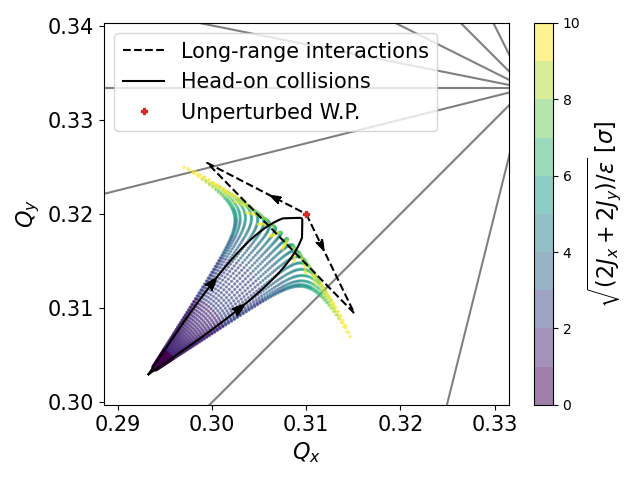

In [2]:

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as sciSpec
import scipy.integrate as integrate
from matplotlib.colors import BoundaryNorm
from matplotlib.patches import FancyArrowPatch


import Backend.Constants as cst
import Backend.Footprint as fp
import Backend.WCTools as WCTools
import Backend.BeamPhysics as BP



def drawArrow(x,y,scale=2,rotate=0,color='C0',alpha=1,label = None):
    ax = plt.gca()
    ax.plot(x[:-2], y[:-2], color=color,alpha=alpha,label=label)
    posA, posB = zip(x[-2:], y[-2:])
    edge_width = 2.*scale
    anglestyle = "arc3,rad={}".format(np.radians(rotate))
    #arrowstyle was 3*edge_width,3*edge_width,edge_width before.
    arrowstyle = "fancy,head_length={},head_width={},tail_width={}".format(3*edge_width, 2*edge_width, 2*edge_width)

    arrow = FancyArrowPatch(posA=posA, posB=posB, arrowstyle=arrowstyle, connectionstyle=anglestyle,color=color)
    ax.add_artist(arrow)

def get_LongRange(coords,knl,twiss):
    betx,bety = twiss['betx'],twiss['bety']
    
    # Quadrupole contribution
    DQx = 1/(4*np.pi)*knl[1]*betx
    DQy = -1/(4*np.pi)*knl[1]*bety
    
    
    # Quadrupole contribution
    DQx += 3/(8*np.pi)*(knl[3]/np.math.factorial(3))*(betx**2 * coords['J_x'] - 2*betx*bety*coords['J_y'])
    DQy += 3/(8*np.pi)*(knl[3]/np.math.factorial(3))*(bety**2 * coords['J_y'] - 2*bety*betx*coords['J_x'])
    
    return DQx,DQy

    
def get_HeadOn(coords,N_p,E,emitt,twiss):
    betx,bety = twiss['betx'],twiss['bety']   
    Jx,Jy = np.array(coords['J_x']),np.array(coords['J_y'])
    
    # Beam-Beam parameter
    gamma = 1+E/cst.m_p_eV
    rp = cst.elec**2/(4*np.pi*cst.eps0*cst.m_p*cst.c**2)
    
    sigx = np.sqrt(betx*emitt)
    sigy = np.sqrt(bety*emitt)
    BBx = -N_p*rp*betx/(2*np.pi*gamma*sigx*(sigx+sigy))
    BBy = -N_p*rp*bety/(2*np.pi*gamma*sigy*(sigx+sigy))
    
    
    # Tune shifts, z is integration varable
    
    DQx = []
    DQy = []
    for Jx,Jy in zip(np.array(coords['J_x']),np.array(coords['J_y'])):
        _DQx,_ = integrate.quad(lambda z: BBx/(1+z**2)*np.exp(-(Jx+Jy)/(2*emitt*(1+z)))*sciSpec.iv(0,Jy/(2*emitt*(1+z)))*(sciSpec.iv(0,Jx/(2*emitt*(1+z)))-sciSpec.iv(1,Jx/(2*emitt*(1+z)))), 0, np.inf)
        _DQy,_ = integrate.quad(lambda z: BBy/(1+z**2)*np.exp(-(Jx+Jy)/(2*emitt*(1+z)))*sciSpec.iv(0,Jx/(2*emitt*(1+z)))*(sciSpec.iv(0,Jy/(2*emitt*(1+z)))-sciSpec.iv(1,Jy/(2*emitt*(1+z)))), 0, np.inf)
        DQx.append(_DQx)
        DQy.append(_DQy)
        
    return np.array(DQx),np.array(DQy)





# Starting Tunes
#=========================================================
Qx_0,Qy_0 = 0.31,0.32
N_p = 1.1e11
E = 6.8e12

# Beta functions
_twiss_ip1 = {'betx':0.330,'bety':0.34}
_twiss_ip5 = {'betx':0.335,'bety':0.347}
#=========================================================

# Generating Coord grid
#=========================================================
#coordinates = fp.generate_coordGrid([0.05,10],[0.01*np.pi/2,0.99*np.pi/2],labels = ['r_n','theta_n'],nPoints=500)
coordinates = fp.generate_coordGrid(np.logspace(np.log10(0.5),np.log10(10),100),
                                    np.linspace(0.01*np.pi/2,0.99*np.pi/2,20),labels = ['r_n','theta_n'])

coordinates.insert(0,'x_n',coordinates['r_n']*np.cos(coordinates['theta_n']))
coordinates.insert(1,'y_n',coordinates['r_n']*np.sin(coordinates['theta_n']))

emitt = 2.5e-6/(1+ 6800e9/cst.m_p_eV)
coordinates.insert(0,'J_x',(coordinates['x_n']**2)*emitt/2)
coordinates.insert(1,'J_y',(coordinates['y_n']**2)*emitt/2)

coordinates.sort_values(by=['r_n'],inplace=True)
#=========================================================


# Generating Contours
#=========================================================

p_by_seg = 1000

cr     = np.array(list(np.linspace(0,10,p_by_seg)) + list(10*np.ones(p_by_seg))             + list(np.flip(np.linspace(0,10,p_by_seg))))
ctheta = np.array(list(np.zeros(p_by_seg))         + list(np.linspace(0,np.pi/2,p_by_seg)) + list(np.pi/2*np.ones(p_by_seg)))
ctour = pd.DataFrame({'r_n':cr,'theta_n':ctheta})

ctour.insert(0,'x_n',ctour['r_n']*np.cos(ctour['theta_n']))
ctour.insert(1,'y_n',ctour['r_n']*np.sin(ctour['theta_n']))


emitt = 2.5e-6/(1+ 6800e9/cst.m_p_eV)
ctour.insert(0,'J_x',(ctour['x_n']**2)*emitt/2)
ctour.insert(1,'J_y',(ctour['y_n']**2)*emitt/2)

#=========================================================


DQx_HO,DQy_HO = 0,0
Cx_HO,Cy_HO = 0,0
for ip in [_twiss_ip1,_twiss_ip5]:
    _Dx,_Dy = get_HeadOn(coordinates,N_p=N_p,E=E,emitt=emitt,twiss=ip)
    DQx_HO += _Dx
    DQy_HO += _Dy
    
    # Contours
    _Dx,_Dy = get_HeadOn(ctour,N_p=N_p,E=E,emitt=emitt,twiss=ip)
    Cx_HO += _Dx
    Cy_HO += _Dy


_wire = WCTools.wire(L=150,x= 0,y=10*np.sqrt(emitt*_twiss_ip1['betx']), I = -2*(2808*N_p)*cst.elec*cst.c/cst.LHC_C)
_knl,_ = _wire.getMultipole_strengths(normalise_at_E = E)

DQx_ip1,DQy_ip1 = get_LongRange(coordinates,knl = _knl,twiss=_twiss_ip1)
Cx_ip1,Cy_ip1 = get_LongRange(ctour,knl = _knl,twiss=_twiss_ip1)

_wire = WCTools.wire(L=150,x= 10*np.sqrt(emitt*_twiss_ip5['betx']),y=0, I = -2*(2808*N_p)*cst.elec*cst.c/cst.LHC_C)
_knl,_ = _wire.getMultipole_strengths(normalise_at_E = E)

DQx_ip5,DQy_ip5 = get_LongRange(coordinates,knl = _knl,twiss=_twiss_ip5)
Cx_ip5,Cy_ip5 = get_LongRange(ctour,knl = _knl,twiss=_twiss_ip5)


for color in ['viridis']:#['viridis', 'plasma', 'inferno', 'magma', 'cividis','winter']:

    window = 0.02
    
    plt.figure()
    BP.plotWorkingDiagram(order = 6,QxRange=np.array([0.25,0.35]),QyRange=np.array([0.25,0.35]),zorder=-1000)
    #plt.scatter(Qx_0 + DQx_HO+ DQx_ip1+ DQx_ip5,Qy_0 + DQy_HO + DQy_ip1 +DQy_ip5,s=2,c=coordinates['r_n'],zorder=1000)
    plt.scatter(Qx_0 + DQx_HO+ DQx_ip1+ DQx_ip5,Qy_0 + DQy_HO + DQy_ip1 +DQy_ip5,s=2,
                c=coordinates['r_n'],alpha=0.5,norm = BoundaryNorm(boundaries=np.linspace(0,10,11), ncolors=256))
    
    
    plt.plot(Qx_0+Cx_ip1+Cx_ip5,Qy_0+Cy_ip1+Cy_ip5,'--',label='Long-range interactions',color='k')
    _x,_y = Qx_0+Cx_ip1+Cx_ip5,Qy_0+Cy_ip1+Cy_ip5
    start,stop = len(_x)//5,len(_x)//5+3
    drawArrow(_x[start:stop],_y[start:stop],scale=1.2,rotate=0,color='k',alpha=1,label = None)
    start,stop = 4*len(_x)//5,4*len(_x)//5+3
    drawArrow(_x[start:stop][::-1],_y[start:stop][::-1],scale=1.2,rotate=0,color='k',alpha=1,label = None)
    
    plt.plot(Qx_0+Cx_HO,Qy_0+Cy_HO,color='k',label='Head-on collisions')   
    _x,_y = Qx_0+Cx_HO,Qy_0+Cy_HO
    start,stop = len(_x)//12,len(_x)//12+3
    drawArrow(_x[start:stop],_y[start:stop],scale=1.5,rotate=0,color='k',alpha=1,label = None)
    start,stop = 11*len(_x)//12,11*len(_x)//12+3
    drawArrow(_x[start:stop][::-1],_y[start:stop][::-1],scale=1.5,rotate=0,color='k',alpha=1,label = None)
    
    plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')
    #h4, = plt.plot([Qx_0],[Qy_0],'o',markersize=3,color='C3')
    plt.axis('equal')

    plt.xlim([0.31-window,0.31+window])
    plt.ylim([0.32-window,0.32+window])
    cbar = plt.colorbar()
    #plt.clim(-2,1.2*np.max(coordinates['r_n']))
    plt.set_cmap(color)
    cbar.ax.set_ylim([0,np.max(coordinates['r_n'])])
    
    plt.legend(fontsize=15)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
    
    plt.xlabel(r'$Q_x$',fontsize=16)
    plt.ylabel(r'$Q_y$',fontsize=16)
    cbar.ax.set_ylabel(r'$\sqrt{(2J_x + 2J_y)/\varepsilon}$ [$\sigma$]',fontsize=16)
    
    plt.tight_layout()
    plt.savefig('./Figures/footprint_analytic.pdf',format='pdf')
    plt.savefig('./Figures/footprint_analytic.png',format='png',dpi=300)






(0.295, 0.34500000000000003)

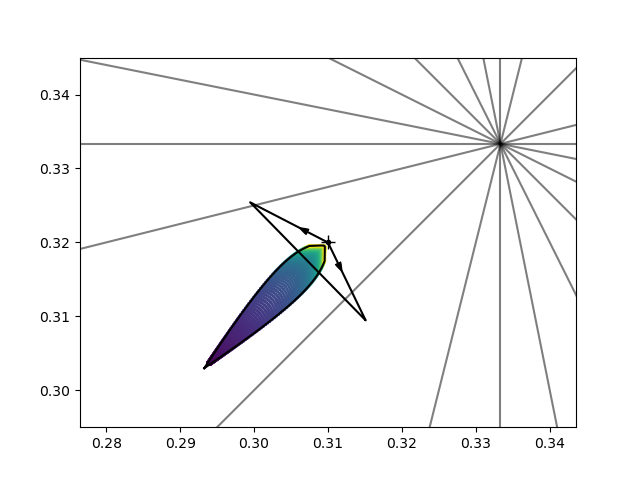

In [151]:
from matplotlib.patches import FancyArrowPatch
def drawArrow(x,y,scale=2,rotate=0,color='C0',alpha=1,label = None):
    ax = plt.gca()
    ax.plot(x[:-2], y[:-2], color=color,alpha=alpha,label=label)
    posA, posB = zip(x[-2:], y[-2:])
    edge_width = 2.*scale
    anglestyle = "arc3,rad={}".format(np.radians(rotate))
    #arrowstyle was 3*edge_width,3*edge_width,edge_width before.
    arrowstyle = "fancy,head_length={},head_width={},tail_width={}".format(3*edge_width, 2*edge_width, edge_width)

    arrow = FancyArrowPatch(posA=posA, posB=posB, arrowstyle=arrowstyle, connectionstyle=anglestyle,color=color)
    ax.add_artist(arrow)
    

plt.figure()
BP.plotWorkingDiagram(order = 6,QxRange=np.array([0.25,0.35]),QyRange=np.array([0.25,0.35]))

#plt.scatter(Qx_0 + DQx_HO+ DQx_ip1+ DQx_ip5,Qy_0 + DQy_HO + DQy_ip1 +DQy_ip5,s=2,
#            c=coordinates['r_n'],norm = BoundaryNorm(boundaries=np.linspace(0,10,11), ncolors=256),zorder=1000)
plt.scatter(Qx_0 + DQx_HO,Qy_0 + DQy_HO,s=2,c=coordinates['r_n'])
plt.plot(Qx_0+Cx_ip1+Cx_ip5,Qy_0+Cy_ip1+Cy_ip5,color='k')

_x,_y = Qx_0+Cx_ip1+Cx_ip5,Qy_0+Cy_ip1+Cy_ip5
start,stop = len(_x)//5,len(_x)//5+3

plt.plot(Qx_0+Cx_HO,Qy_0+Cy_HO,color='k')
drawArrow(_x[start:stop],_y[start:stop],scale=1,rotate=0,color='k',alpha=1,label = None)
start,stop = 4*len(_x)//5,4*len(_x)//5+3
drawArrow(_x[start:stop][::-1],_y[start:stop][::-1],scale=1,rotate=0,color='k',alpha=1,label = None)
plt.plot([Qx_0],[Qy_0],'+',markersize=10,color='k')
plt.plot([Qx_0],[Qy_0],'.',color='k')
plt.axis('equal')

plt.xlim([0.31-window,0.31+window])
plt.ylim([0.32-window,0.32+window])
#cbar = plt.colorbar()
#plt.clim(-2,1.2*np.max(coordinates['r_n']))
#plt.set_cmap(color)
#cbar.ax.set_ylim([0,np.max(coordinates['r_n'])])

In [108]:
np.flip(np.linspace(0,10,50))

array([10.        ,  9.79591837,  9.59183673,  9.3877551 ,  9.18367347,
        8.97959184,  8.7755102 ,  8.57142857,  8.36734694,  8.16326531,
        7.95918367,  7.75510204,  7.55102041,  7.34693878,  7.14285714,
        6.93877551,  6.73469388,  6.53061224,  6.32653061,  6.12244898,
        5.91836735,  5.71428571,  5.51020408,  5.30612245,  5.10204082,
        4.89795918,  4.69387755,  4.48979592,  4.28571429,  4.08163265,
        3.87755102,  3.67346939,  3.46938776,  3.26530612,  3.06122449,
        2.85714286,  2.65306122,  2.44897959,  2.24489796,  2.04081633,
        1.83673469,  1.63265306,  1.42857143,  1.2244898 ,  1.02040816,
        0.81632653,  0.6122449 ,  0.40816327,  0.20408163,  0.        ])

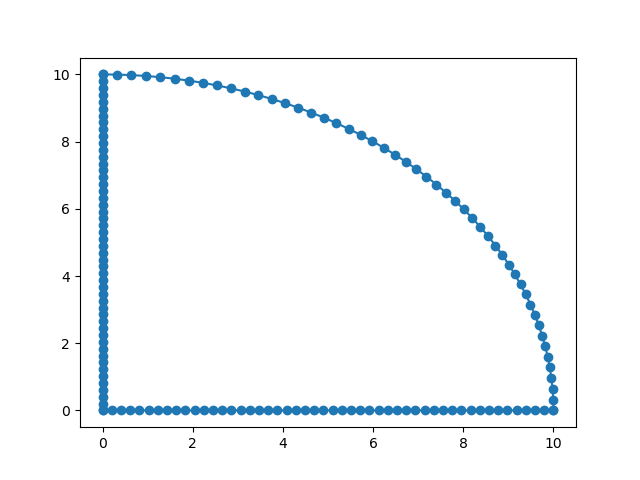

In [113]:


cr     = np.array(list(np.linspace(0,10,50)) + list(10*np.ones(50))             + list(np.flip(np.linspace(0,10,50))))
ctheta = np.array(list(np.zeros(50))         + list(np.linspace(0,np.pi/2,50)) + list(np.pi/2*np.ones(50)))

plt.figure()
plt.plot(cr*np.cos(ctheta),cr*np.sin(ctheta),'-o')

In [111]:
cr

array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.  

In [55]:
ctour[ctour['y_n']!=0] = 

,J_x,J_y,x_n,y_n,r_n,theta_n
100,1.616485e-43,4.311317e-11,3.061617e-17,0.500000,0.500000,1.570796
101,1.717335e-43,4.580295e-11,3.155677e-17,0.515361,0.515361,1.570796
102,1.824478e-43,4.866053e-11,3.252627e-17,0.531194,0.531194,1.570796
103,1.938304e-43,5.169640e-11,3.352556e-17,0.547514,0.547514,1.570796
104,2.059233e-43,5.492167e-11,3.455554e-17,0.564335,0.564335,1.570796
...,...,...,...,...,...,...
195,5.075723e-41,1.353743e-08,5.425178e-16,8.859988,8.859988,1.570796
196,5.392391e-41,1.438201e-08,5.591852e-16,9.132188,9.132188,1.570796
197,5.728815e-41,1.527929e-08,5.763648e-16,9.412751,9.412751,1.570796
198,6.086228e-41,1.623254e-08,5.940721e-16,9.701933,9.701933,1.570796


In [61]:
newIndex = np.array(ctour.index)

In [75]:
newIndex

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 199, 198, 197, 196,
       195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183,
       182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170,
       169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157,
       156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144,
       143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131,
       130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 11

In [64]:
flipIndex = np.min(ctour[ctour['y_n']!=0].index)
newIndex = np.array(ctour.index)
newIndex[flipIndex:] = newIndex[-1:flipIndex-1:-1]
ctour.reindex(index=newIndex)

In [86]:
ctour = ctour.reindex(index=newIndex).reset_index()

In [87]:
ctour

,index,J_x,J_y,x_n,y_n,r_n,theta_n
0,0,4.311317e-11,0.000000e+00,5.000000e-01,0.000000,0.500000,0.000000
1,1,4.580295e-11,0.000000e+00,5.153612e-01,0.000000,0.515361,0.000000
2,2,4.866053e-11,0.000000e+00,5.311943e-01,0.000000,0.531194,0.000000
3,3,5.169640e-11,0.000000e+00,5.475139e-01,0.000000,0.547514,0.000000
4,4,5.492167e-11,0.000000e+00,5.643349e-01,0.000000,0.564335,0.000000
...,...,...,...,...,...,...,...
195,104,2.059233e-43,5.492167e-11,3.455554e-17,0.564335,0.564335,1.570796
196,103,1.938304e-43,5.169640e-11,3.352556e-17,0.547514,0.547514,1.570796
197,102,1.824478e-43,4.866053e-11,3.252627e-17,0.531194,0.531194,1.570796
198,101,1.717335e-43,4.580295e-11,3.155677e-17,0.515361,0.515361,1.570796


# OLD

(0.3077901625708932,
 0.31425410081484095,
 0.31767444434882874,
 0.3242801041517517)

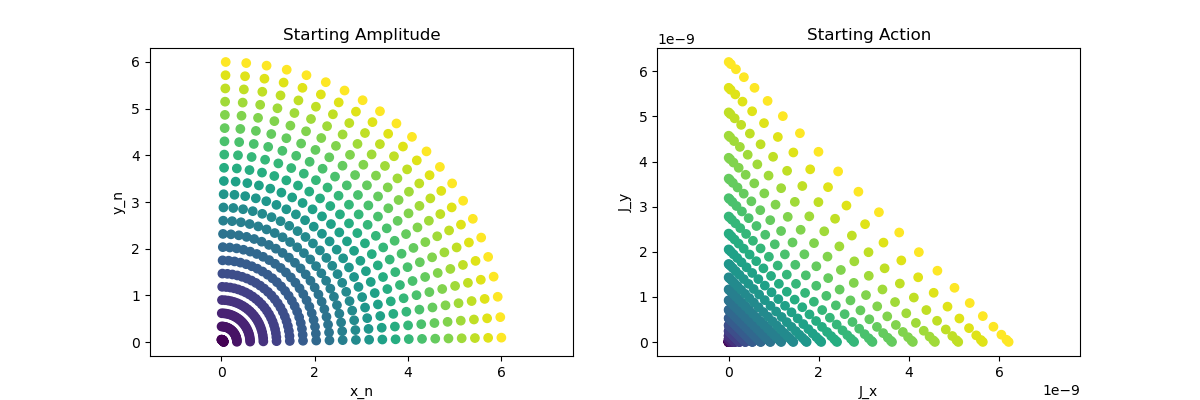

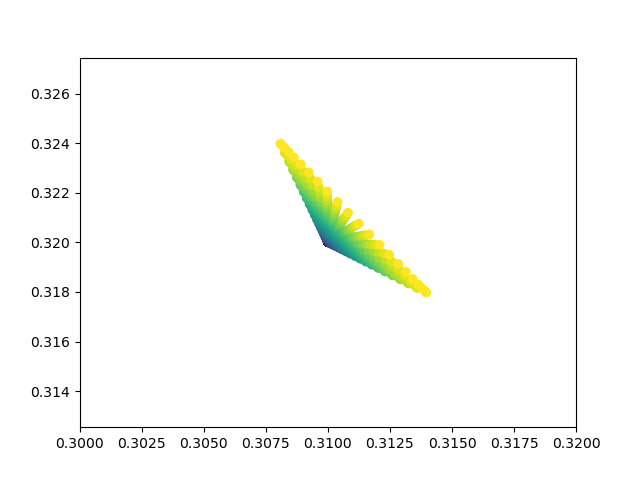

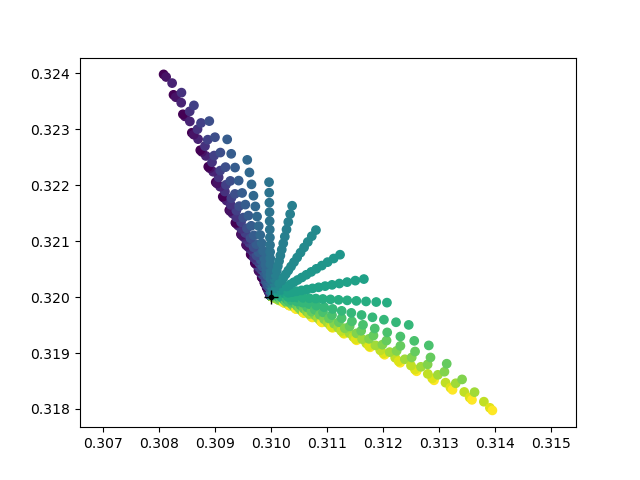

In [53]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as sciSpec

import Backend.Constants as cst
import Backend.Footprint as fp
import Backend.WCTools as WCTools



# Generating Coord grid
coordinates = fp.generate_coordGrid([0.05,6],[0.01*np.pi/2,0.99*np.pi/2],labels = ['r_n','theta_n'],nPoints=500)

coordinates.insert(0,'x_n',coordinates['r_n']*np.cos(coordinates['theta_n']))
coordinates.insert(1,'y_n',coordinates['r_n']*np.sin(coordinates['theta_n']))

emitt = 2.5e-6/(1+ 6800e9/cst.m_p_eV)
coordinates.insert(0,'J_x',(coordinates['x_n']**2)*emitt/2)
coordinates.insert(1,'J_y',(coordinates['y_n']**2)*emitt/2)

coordinates.sort_values(by=['r_n'],inplace=True)

def get_tune_shift(coords,knl,twiss):
    betx,bety = twiss['betx'],twiss['bety']
    
    # Quadrupole contribution
    DQx = 1/(4*np.pi)*knl[1]*betx
    DQy = -1/(4*np.pi)*knl[1]*bety
    
    
    # Quadrupole contribution
    DQx += 3/(8*np.pi)*(knl[3]/np.math.factorial(3))*(betx**2 * coords['J_x'] - 2*betx*bety*coords['J_y'])
    DQy += 3/(8*np.pi)*(knl[3]/np.math.factorial(3))*(bety**2 * coords['J_y'] - 2*bety*betx*coords['J_x'])
    
    return DQx,DQy

def get_HeadOn(coords,N_p,E,emitt,twiss):
    betx,bety = twiss['betx'],twiss['bety']
    
    gamma = 1+E/cst.m_p_eV
    rp = cst.elec**2/(4*np.pi*cst.eps0*cst.m_p*cst.c**2)
    
    sigx = np.sqrt(betx*emitt)
    sigy = np.sqrt(bety*emitt)
    BBx = N_p*rp*betx/(2*np.pi*gamma*sigx*(sigx+sigy))
    BBy = N_p*rp*bety/(2*np.pi*gamma*sigy*(sigx+sigy))
    
    #linear part:
    DQx = 0
    DQy = 0
    
    #Non-linear part
    Ax = coords['x_n']**2
    Ay = coords['y_n']**2
    DQx += BBx*4/Ax*(1-np.i0(Ax/4)*np.exp(-Ax/4))
    DQy += BBy*4/Ay*(1-np.i0(Ay/4)*np.exp(-Ay/4))

    return DQx,DQy

# Starting Tunes
Qx_0,Qy_0 = 0.31,0.32

# Beta functions
_twiss_ip1 = {'betx':0.330,'bety':0.34}
_twiss_ip5 = {'betx':0.335,'bety':0.347}


# Find knl for something similar to BB
N_p = 1.15e11
_wire = WCTools.wire(L=150,x= 0,y=10*np.sqrt(emitt*_twiss_ip1['betx']), I = 2*(2808*N_p)*cst.elec*cst.c/cst.LHC_C)
_knl,_ = _wire.getMultipole_strengths(normalise_at_E = 6.8e12)

DQx_ip1,DQy_ip1 = get_tune_shift(coordinates,knl = _knl,twiss=_twiss_ip1)

_wire = WCTools.wire(L=150,x= 10*np.sqrt(emitt*_twiss_ip5['betx']),y=0, I = 2*(2808*N_p)*cst.elec*cst.c/cst.LHC_C)
_knl,_ = _wire.getMultipole_strengths(normalise_at_E = 6.8e12)

DQx_ip5,DQy_ip5 = get_tune_shift(coordinates,knl = _knl,twiss=_twiss_ip5)

Qx = Qx_0 + DQx_ip1 + DQx_ip5
Qy = Qy_0 + DQy_ip1 + DQy_ip5





# Plotting
#==================================================================================
fig, axes = plt.subplots(1, 2,figsize=(12,4))

plt.sca(axes[0])
plt.title('Starting Amplitude')
plt.scatter(coordinates['x_n'],coordinates['y_n'],c=coordinates['r_n'])
plt.xlabel('x_n');
plt.ylabel('y_n');
plt.axis('equal');

plt.sca(axes[1])
plt.title('Starting Action')
plt.scatter(coordinates['J_x'],coordinates['J_y'],c=coordinates['r_n'])
plt.xlabel('J_x');
plt.ylabel('J_y');
plt.axis('equal');


plt.figure()
plt.scatter(Qx,Qy,c=coordinates['r_n'])
#plt.plot([0.31],[0.32],'+',markersize=10,color='k')
#plt.plot([0.31],[0.32],'.',color='k')
plt.axis('equal')
window = 0.01
plt.xlim([0.31-window,0.31+window])
plt.ylim([0.32-window,0.32+window])


plt.figure()
plt.scatter(Qx,Qy,c=coordinates['theta_n'])
plt.plot([0.31],[0.32],'+',markersize=10,color='k')
plt.plot([0.31],[0.32],'.',color='k')
plt.axis('equal')
#plt.xlim([0.31-0.002,0.31+0.002])
#plt.ylim([0.32-0.002,0.32+0.002])






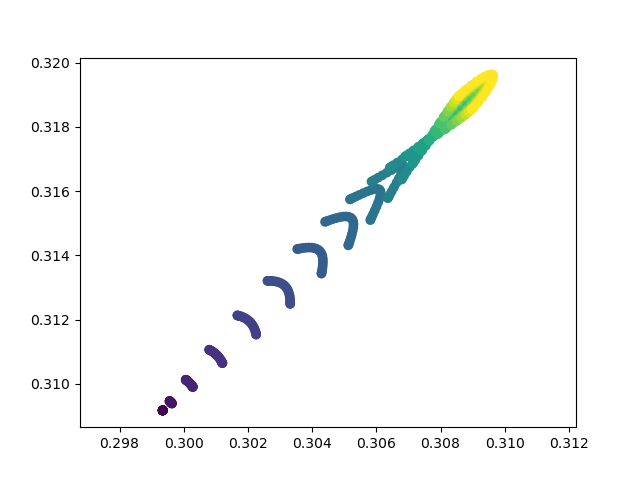

In [94]:
def get_HeadOn(coords,N_p,E,emitt,twiss):
    betx,bety = twiss['betx'],twiss['bety']
    
    gamma = 1+E/cst.m_p_eV
    rp = cst.elec**2/(4*np.pi*cst.eps0*cst.m_p*cst.c**2)
    
    sigx = np.sqrt(betx*emitt)
    sigy = np.sqrt(bety*emitt)
    BBx = -N_p*rp*betx/(2*np.pi*gamma*sigx*(sigx+sigy))
    BBy = -N_p*rp*bety/(2*np.pi*gamma*sigy*(sigx+sigy))
    
    #linear part:
    DQx = 0
    DQy = 0
    
    #Non-linear part
    A = coords['x_n']**2 + coords['y_n']**2
    Ax = coords['x_n']**2
    Ay = coords['y_n']**2
    
    #DQx += BBx*4/Ax*(1-np.i0(Ax/4)*np.exp(-Ax/4))
    #DQy += BBy*4/Ay*(1-np.i0(Ay/4)*np.exp(-Ay/4))

    DQx += BBx*4/Ax*(1-np.i0(Ax/4)*np.exp(-Ax/4))*(1-np.i0(Ay/4)*np.exp(-Ay/4))
    DQy += BBy*4/Ay*(1-np.i0(Ay/4)*np.exp(-Ay/4))*(1-np.i0(Ax/4)*np.exp(-Ay/4))
    
    return DQx,DQy



DQx_HO,DQy_HO = 0,0
for ip in [_twiss_ip1,_twiss_ip5]:
    _Dx,_Dy = get_HeadOn(coordinates,N_p=1.1e11,E=6.8e12,emitt=emitt,twiss=ip)
    DQx_HO += _Dx
    DQy_HO += _Dy
    
plt.figure()
plt.scatter(Qx_0 + DQx_HO,Qy_0 + DQy_HO,c=coordinates['r_n'])
#plt.plot([0.31],[0.32],'+',markersize=10,color='k')
#plt.plot([0.31],[0.32],'.',color='k')
plt.axis('equal')
window = 0.01
#plt.xlim([0.31-window,0.31+window])
#plt.ylim([0.32-window,0.32+window])

In [48]:
betx,bety = _twiss_ip1['betx'],_twiss_ip1['bety']

gamma = 1+6.8e12/cst.m_p_eV
rp = cst.elec**2/(4*np.pi*cst.eps0*cst.m_p*cst.c**2)

sigx = np.sqrt(betx*emitt)
sigy = np.sqrt(bety*emitt)
BBx = N_p*rp*betx/(2*np.pi*gamma*sigx*(sigx+sigy))
BBy = N_p*rp*bety/(2*np.pi*gamma*sigy*(sigx+sigy))

#linear part:
DQx = BBx
DQy = BBy

#Non-linear part
coords = coordinates.copy()
Ax = coords['J_x']**2 + coords['J_y']**2
Ay = coords['J_y']**2 + coords['J_x']**2
DQx += BBx*4/Ax*(1-np.i0(Ax/4)*np.exp(-Ax/4))
DQy += BBy*4/Ay*(1-np.i0(Ay/4)*np.exp(-Ay/4))

In [41]:
BBx

0.005575934167177512

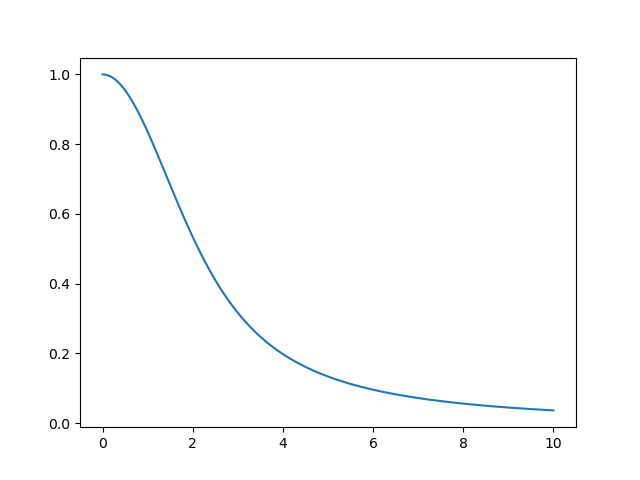

In [47]:
def test(y):
    x = y**2
    return 4/x*(1-np.i0(x/4)*np.exp(-x/4))

x = np.linspace(0.001,10,200)
plt.figure()
plt.plot(x,test(x))

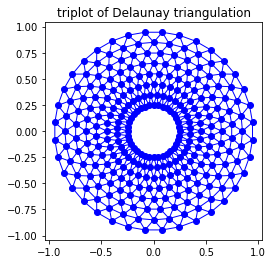

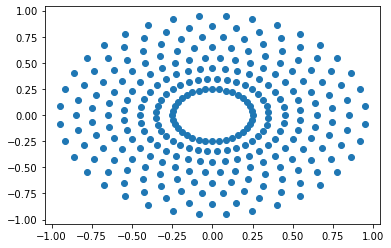

In [11]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

# First create the x and y coordinates of the points.
n_angles = 36
n_radii = 8
min_radius = 0.25
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += np.pi / n_angles

x = (radii * np.cos(angles)).flatten()
y = (radii * np.sin(angles)).flatten()

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(x, y)

# Mask off unwanted triangles.
triang.set_mask(np.hypot(x[triang.triangles].mean(axis=1),
                         y[triang.triangles].mean(axis=1))
                < min_radius)


fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.triplot(triang, 'bo-', lw=1)
ax1.set_title('triplot of Delaunay triangulation')
plt.show()

plt.figure()
plt.plot(x,y,'o')


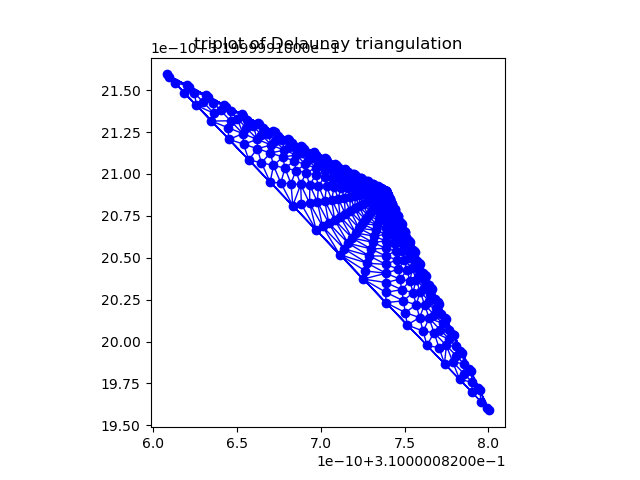

In [26]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np



# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(Qx,Qy)

# Mask off unwanted triangles.
#triang.set_mask(np.hypot(x[triang.triangles].mean(axis=1),
#                         y[triang.triangles].mean(axis=1))
#                < min_radius)


fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.triplot(triang, 'bo-', lw=1)
ax1.set_title('triplot of Delaunay triangulation')
plt.show()

#plt.figure()
#plt.plot(x,y,'o')

In [26]:
import pandas as pd
import Backend.BeamPhysics as BP


Q_rho,Q_phi = BP.cart2pol(Qx, Qy)
data = pd.DataFrame({'Qx':Qx,'Qy':Qy,'Q_rho':Q_rho,'Q_phi':Q_phi})

data

,Qx,Qy,Q_rho,Q_phi
0,0.333875,0.296122,0.446275,0.725544
1,0.334326,0.295222,0.446015,0.723363
2,0.335558,0.292757,0.445315,0.717383
3,0.337572,0.288727,0.444205,0.707566
4,0.340368,0.283133,0.442735,0.693858
...,...,...,...,...
95,0.313720,0.306200,0.438382,0.773267
96,0.304997,0.310560,0.435282,0.794435
97,0.294709,0.315702,0.431881,0.819776
98,0.282856,0.321626,0.428312,0.849447


In [42]:
Qx

0     0.333875
1     0.334326
2     0.335558
3     0.337572
4     0.340368
        ...   
95    0.313720
96    0.304997
97    0.294709
98    0.282856
99    0.269439
Length: 100, dtype: float64

In [45]:
Qx

0     0.333875
1     0.334326
2     0.335558
3     0.337572
4     0.340368
        ...   
95    0.313720
96    0.304997
97    0.294709
98    0.282856
99    0.269439
Length: 100, dtype: float64

(-0.05, 5.1)

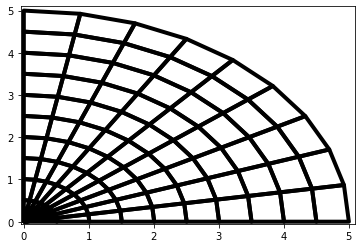

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.collections
import numpy as np
import pandas as pd


def draw_footprint(A, axis_object=None, figure_object=None, axis=0, linewidth=4):
    '''
    Input A should be a 3-D numpy array with shape (Nx,Ny,2)
    representing a 2-D array of (x,y) points. This function
    will draw lines between adjacent points in the 2-D array.
    '''
    if len(A.shape) != 3:
        print('ERROR: Invalid input matrix')
        return None
    if A.shape[2] != 2:
        print('ERROR: Points are not defined in 2D space')
        return None

    
    
    sx = A.shape[0]-1
    sy = A.shape[1]-1

    p1 = A[:-1,:-1,:].reshape(sx*sy,2)[:,:]
    p2 = A[1:,:-1,:].reshape(sx*sy,2)[:]
    p3 = A[1:,1:,:].reshape(sx*sy,2)[:]
    p4 = A[:-1,1:,:].reshape(sx*sy,2)[:]

    #Stack endpoints to form polygons
    Polygons = np.stack((p1,p2,p3,p4))
    #transpose polygons
    Polygons = np.transpose(Polygons,(1,0,2))
    patches = list(map(matplotlib.patches.Polygon,Polygons))

    #assign colors
    patch_colors = [(0,0,0) for a in Polygons]
    #patch_colors[(sx-1)*sy:] = [(0,1,0)]*sy
    #patch_colors[(sy-1)::sy] = [(0,0,1)]*sx

    p_collection = matplotlib.collections.PatchCollection(patches,facecolors=[],linewidth=linewidth,edgecolor=patch_colors)

    if axis_object is None:
        if figure_object:
            fig = figure_object
        else:
            fig = plt.figure()
        if len(fig.axes) == 0:
            plt.subplot(1,1,1)
        if axis >= len(fig.axes) or axis < 0:
            i = 0
        else:
            i = axis
        ax = fig.axes[i]
    else:
        ax = axis_object
        fig = None

    ax.add_collection(p_collection)

    return fig


def initial_xy_polar(r_min, r_max, r_N, theta_min, theta_max, theta_N):
    return np.array([[(r*np.cos(theta),r*np.sin(theta)) for r in np.linspace(r_min,r_max,r_N)] for theta in np.linspace(theta_min,theta_max,theta_N)])

def initial_xy_cartesian(x_min, x_max, x_N, y_min, y_max, y_N):
    return np.array([[(x,y) for x in np.linspace(x_min,x_max,x_N)] for y in np.linspace(y_min,y_max,y_N)])


coords_matrix = initial_xy_polar(0.01,5,11,0.,np.pi/2.,10)
fig = draw_footprint(coords_matrix)
fig.axes[0].set_xlim(-0.05,5.1)
fig.axes[0].set_ylim(-0.05,5.1)

TypeError: unhashable type: 'numpy.ndarray'

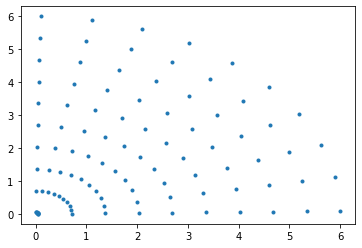

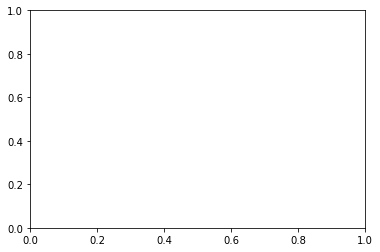

In [62]:
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.collections
import matplotlib.colors
import numpy as np
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import Backend.Constants as cst
import Backend.Footprint as fp
import Backend.WCTools as WCTools
import Backend.BeamPhysics as BP



# Generating Coord grid
coordinates = fp.generate_coordGrid([0.05,6],[0.01*np.pi/2,0.99*np.pi/2],labels = ['r_n','theta_n'],nPoints=100)

coordinates.insert(0,'x_n',coordinates['r_n']*np.cos(coordinates['theta_n']))
coordinates.insert(1,'y_n',coordinates['r_n']*np.sin(coordinates['theta_n']))

coordinates.insert(0,'J_x',(coordinates['x_n']**2)/2)
coordinates.insert(1,'J_y',(coordinates['y_n']**2)/2)


def wireframe(x,y, linewidth=1):
    '''
    Input A should be a 3-D numpy array with shape (Nx,Ny,2)
    representing a 2-D array of (x,y) points. This function
    will draw lines between adjacent points in the 2-D array.
    '''


    
    # Creating Nx.Ny.2 structure, sort with angle to correctly link points
    r,theta = BP.cart2pol(x, y)
    sorting = np.argsort(theta)  
    A = np.array([[(_r*np.cos(_theta),_r*np.sin(_theta)) for _r in r[sorting]] for _theta in theta[sorting]])

    
    sx = A.shape[0]-1
    sy = A.shape[1]-1

    p1 = A[:-1,:-1,:].reshape(sx*sy,2)[:,:]
    p2 = A[1:,:-1,:].reshape(sx*sy,2)[:]
    p3 = A[1:,1:,:].reshape(sx*sy,2)[:]
    p4 = A[:-1,1:,:].reshape(sx*sy,2)[:]

    #Stack endpoints to form polygons
    Polygons = np.stack((p1,p2,p3,p4))
    #transpose polygons
    Polygons = np.transpose(Polygons,(1,0,2))
    #print(Polygons)
    patches = []
    ax = plt.gca()
    for poly in list(set(Polygons)):
        thisPatch = matplotlib.patches.Polygon(poly,fill=False,alpha=0.1,edgecolor='C0',linewidth=1)
        ax.add_patch(thisPatch)
    #patches = list(map(matplotlib.patches.Polygon,Polygons))

    #assign colors
    #patch_colors = [matplotlib.colors.to_rgba('blue',0.2) for a in Polygons]

    #p_collection = matplotlib.collections.PatchCollection(patches)

    
    #ax.add_collection(p_collection)

def initial_xy_polar(r_min, r_max, r_N, theta_min, theta_max, theta_N):
    return np.array([[(r*np.cos(theta),r*np.sin(theta)) for r in np.linspace(r_min,r_max,r_N)] for theta in np.linspace(theta_min,theta_max,theta_N)])

def initial_xy_cartesian(x_min, x_max, x_N, y_min, y_max, y_N):
    return np.array([[(x,y) for x in np.linspace(x_min,x_max,x_N)] for y in np.linspace(y_min,y_max,y_N)])


plt.figure()
plt.plot(coordinates['x_n'],coordinates['y_n'],'.')

plt.figure()
wireframe(coordinates['x_n'],coordinates['y_n'])
plt.xlim([0,10])
plt.ylim([0,10])


sorting = np.argsort(coordinates['r_n'])
plt.figure()
plt.fill(coordinates['x_n'][sorting],coordinates['y_n'][sorting])

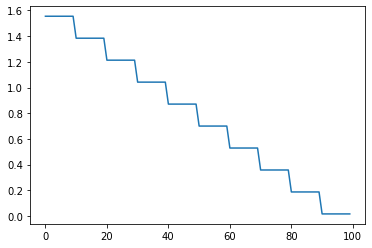

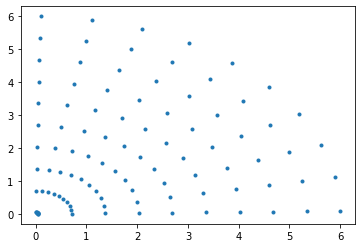

In [116]:
sorting = np.argsort(coordinates['x_n']**2 + coordinates['y_n']**2)
plt.figure()
plt.plot(coordinates['x_n'][sorting],coordinates['y_n'][sorting],'.')

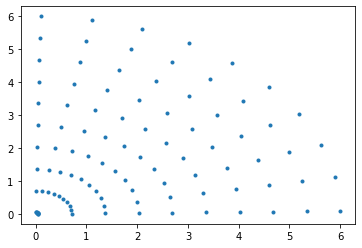

In [81]:
plt.figure()
plt.plot(X[:,0],X[:,1],'.')

In [83]:
len(X)

100

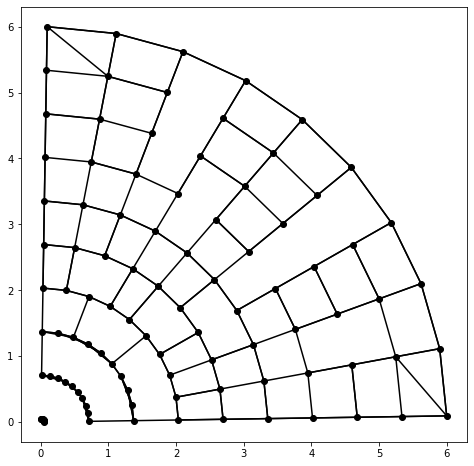

In [105]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

# Generating Coord grid
coordinates = fp.generate_coordGrid([0.05,6],[0.01*np.pi/2,0.99*np.pi/2],labels = ['r_n','theta_n'],nPoints=100)

coordinates.insert(0,'x_n',coordinates['r_n']*np.cos(coordinates['theta_n']))
coordinates.insert(1,'y_n',coordinates['r_n']*np.sin(coordinates['theta_n']))

coordinates.insert(0,'J_x',(coordinates['x_n']**2)/2)
coordinates.insert(1,'J_y',(coordinates['y_n']**2)/2)

X = np.array(coordinates.loc[:,['x_n','y_n']])
k = 4
N = len(X)

#X_polar = np.array(coordinates.loc[:,['x_n','y_n','r_n']])

# matrix of pairwise Euclidean distances
distmat = squareform(pdist(X, 'euclidean'))
#distmat = squareform(pdist(X, 'euclidean'))

# select the kNN for each datapoint
neighbors = np.sort(np.argsort(distmat, axis=1)[:, 0:k])

# get edge coordinates
edge_coo = np.zeros((N, k, 2, 2))
for i in np.arange(N):
    for j in np.arange(k):
        edge_coo[i, j, :, 0] = np.array([X[i,:][0], X[neighbors[i, j], :][0]])
        edge_coo[i, j, :, 1] = np.array([X[i,:][1], X[neighbors[i, j], :][1]])

# create line artists
lines = LineCollection(edge_coo.reshape((N*k, 2, 2)), color='black')

fig, ax = plt.subplots(1,1,figsize = (8, 8))
ax.scatter(X[:,0], X[:,1], c = 'black')
ax.add_artist(lines)
plt.show()

In [110]:
len(coordinates['x_n'])

100

In [51]:
x = np.linspace(1,10,10)
y = np.linspace(1,10,10)
np.shape(np.array([[(_x,_y) for _x in x] for _y in y]))

(10, 10, 2)

In [ ]:
np.array([np.repeat(x,len(y)),np.tile(y,len(x))]).reshape(10,10,2)

array([[[ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [ 2.,  2.],
        [ 2.,  2.],
        [ 2.,  2.],
        [ 2.,  2.],
        [ 2.,  2.]],

       [[ 3.,  3.],
        [ 3.,  3.],
        [ 3.,  3.],
        [ 3.,  3.],
        [ 3.,  3.],
        [ 4.,  4.],
        [ 4.,  4.],
        [ 4.,  4.],
        [ 4.,  4.],
        [ 4.,  4.]],

       [[ 5.,  5.],
        [ 5.,  5.],
        [ 5.,  5.],
        [ 5.,  5.],
        [ 5.,  5.],
        [ 6.,  6.],
        [ 6.,  6.],
        [ 6.,  6.],
        [ 6.,  6.],
        [ 6.,  6.]],

       [[ 7.,  7.],
        [ 7.,  7.],
        [ 7.,  7.],
        [ 7.,  7.],
        [ 7.,  7.],
        [ 8.,  8.],
        [ 8.,  8.],
        [ 8.,  8.],
        [ 8.,  8.],
        [ 8.,  8.]],

       [[ 9.,  9.],
        [ 9.,  9.],
        [ 9.,  9.],
        [ 9.,  9.],
        [ 9.,  9.],
        [10., 10.],
        [10., 10.],
        [10., 10.],
        [10., 10.],
        [10.

In [29]:
np.array(np.meshgrid(np.linspace(1,10,10),np.linspace(1,10,10))).reshape(10,10,2)

array([[[ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.],
        [ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.]],

       [[ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.],
        [ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.]],

       [[ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.],
        [ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.]],

       [[ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.],
        [ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.]],

       [[ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.],
        [ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9.

In [3]:
import Backend.Constants as cst
import Backend.Footprint as fp
import Backend.WCTools as WCTools

_wire = WCTools.wire(L=1,x= 12e-3,y=0, I = 2*cst.c*(2808*1.1e11)*cst.elec/cst.LHC_C)
_knl,_ = _wire.getMultipole_strengths(normalise_at_E = 7e12)

In [4]:
_knl

array([-7.94471720e-10, -6.62059767e-08, -1.10343294e-05, -2.75858236e-03,
       -9.19527454e-01, -3.83136439e+02, -1.91568220e+05, -1.11748128e+08,
       -7.44987520e+10, -5.58740640e+13, -4.65617200e+16, -4.26815767e+19,
       -4.26815767e+22, -4.62383747e+25, -5.39447705e+28, -6.74309632e+31,
       -8.99079509e+34, -1.27369597e+38, -1.91054396e+41, -3.02502793e+44,
       -5.04171322e+47])

,J_x,J_y,x_n,y_n,r_n,theta_n
0,0.001250,3.083998e-07,0.049994,0.000785,0.050000,0.015708
1,0.252777,6.238052e-05,0.711023,0.011170,0.711111,0.015708
2,0.941265,2.322859e-04,1.372053,0.021554,1.372222,0.015708
3,2.066712,5.100247e-04,2.033082,0.031938,2.033333,0.015708
4,3.629120,8.955967e-04,2.694112,0.042322,2.694444,0.015708


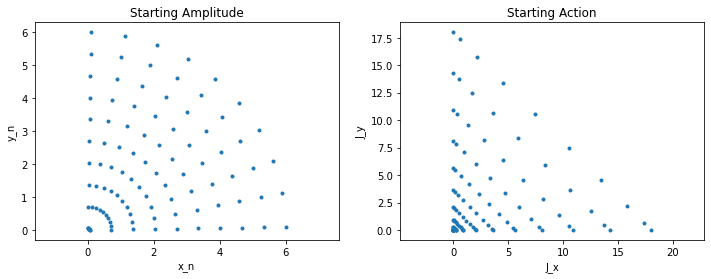

In [13]:

coordinates = fp.generate_coordGrid([0.05,6],[0.01*np.pi/2,0.99*np.pi/2],labels = ['r_n','theta_n'],nPoints=100)

coordinates.insert(0,'x_n',coordinates['r_n']*np.cos(coordinates['theta_n']))
coordinates.insert(1,'y_n',coordinates['r_n']*np.sin(coordinates['theta_n']))

coordinates.insert(0,'J_x',(coordinates['x_n']**2)/2)
coordinates.insert(1,'J_y',(coordinates['y_n']**2)/2)



display(coordinates.head())

